In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

random.seed(42)

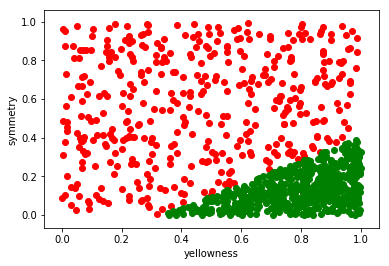

In [2]:
%matplotlib inline
data = np.loadtxt("data.csv", delimiter=",")
pears = data[:, 2] == 1
apples = np.logical_not(pears)
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
plt.show()

In [3]:
class Perceptron:

    def __init__(self, w, b):
        """
        Инициализируем наш объект - перцептрон.
        w - вектор весов размера (m, 1), где m - количество переменных
        b - число
        """
        
        self.w = w
        self.b = b

    def forward_pass(self, single_input):
        """
        Метод рассчитывает ответ перцептрона при предъявлении одного примера
        single_input - вектор примера размера (m, 1).
        Метод возвращает число (0 или 1) или boolean (True/False)
        """
        
        result = 0
        for i in range(0, len(self.w)):
            result += self.w[i] * single_input[i]
        result += self.b
        
        if result > 0:
            return 1
        else:
            return 0

    def vectorized_forward_pass(self, input_matrix):
        """
        Метод рассчитывает ответ перцептрона при предъявлении набора примеров
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных
        Возвращает вертикальный вектор размера (n, 1) с ответами перцептрона
        (элементы вектора - boolean или целые числа (0 или 1))
        """
        
        return input_matrix.dot(self.w) + self.b > 0
    
    def train_on_single_example(self, example, y):
        """
        принимает вектор активации входов example формы (m, 1) 
        и правильный ответ для него (число 0 или 1 или boolean),
        обновляет значения весов перцептрона в соответствии с этим примером
        и возвращает размер ошибки, которая случилась на этом примере до изменения весов (0 или 1)
        (на её основании мы потом построим интересный график)
        """
        error = y - self.vectorized_forward_pass(example.T)
        self.w += error*example
        self.b += error
        return error
    
    def train_until_convergence(self, input_matrix, y, max_steps=1e8):
        """
        input_matrix - матрица входов размера (n, m),
        y - вектор правильных ответов размера (n, 1) (y[i] - правильный ответ на пример input_matrix[i]),
        max_steps - максимальное количество шагов.
        Применяем train_on_single_example, пока не перестанем ошибаться или до умопомрачения.
        Константа max_steps - наше понимание того, что считать умопомрачением.
        """
        i = 0
        errors = 1
        while errors and i < max_steps:
            i += 1
            errors = 0
            for example, answer in zip(input_matrix, y):
                example = example.reshape((example.size, 1))
                error = self.train_on_single_example(example, answer)
                errors += int(error)  # int(True) = 1, int(False) = 0, так что можно не делать if

In [4]:
def create_perceptron(m):
    """Создаём перцептрон со случайными весами и m входами"""
    w = np.random.random((m, 1))
    return Perceptron(w, 1)

def test_v_f_p(n, m):
        """
        Расчитывает для перцептрона с m входами
        с помощью методов forward_pass и vectorized_forward_pass
        n ответов перцептрона на случайных данных.
        Возвращает время, затраченное vectorized_forward_pass и forward_pass
        на эти расчёты.
        """
        
        p = create_perceptron(m)
        input_m = np.random.random_sample((n, m))
        
        start = time.process_time()
        vec = p.vectorized_forward_pass(input_m)
        end = time.process_time()
        vector_time = end - start
        
        start = time.process_time()
        for i in range(0, n):
            p.forward_pass(input_m[i]) 
        end = time.process_time()
        plain_time = end - start
        return [vector_time, plain_time]


test_v_f_p(300, 5151)

[0.014749999999999819, 10.499594]

In [5]:
t = np.random.random_sample((4, 3))
t

array([[0.87278585, 0.40042647, 0.05032583],
       [0.19826953, 0.71889801, 0.21797646],
       [0.92935617, 0.69678708, 0.13811211],
       [0.26199684, 0.34879118, 0.96985556]])

In [24]:
w = np.random.random((3, 1))
w

array([[0.96826158],
       [0.31342418]])

In [7]:
def plot_line(coefs):
    """
    рисует разделяющую прямую, соответствующую весам, переданным в coefs = (weights, bias), 
    где weights - ndarray формы (2, 1), bias - число
    """
    w, bias = coefs
    a, b = - w[0][0] / w[1][0], - bias / w[1][0]
    xx = np.linspace(*plt.xlim())
    line.set_data(xx, a*xx + b)
    
def step_by_step_weights(p, input_matrix, y, max_steps=1e6):
    """
    обучает перцептрон последовательно на каждой строчке входных данных, 
    возвращает обновлённые веса при каждом их изменении
    p - объект класса Perceptron
    """
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error  # здесь мы упадём, если вы забыли вернуть размер ошибки из train_on_single_example
            if error:  # будем обновлять положение линии только тогда, когда она изменила своё положение
                yield p.w, p.b
                
    for _ in range(20): yield p.w, p.b
        
def step_by_step_errors(p, input_matrix, y, max_steps=1e6):
    """
    обучает перцептрон последовательно на каждой строчке входных данных, 
    на каждом шаге обучения запоминает количество неправильно классифицированных примеров
    и возвращает список из этих количеств
    """
    def count_errors():
        return np.abs(p.vectorized_forward_pass(input_matrix).astype(np.int) - y).sum()
    errors_list = [count_errors()]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error
            errors_list.append(count_errors())
    return errors_list



<IPython.core.display.Javascript object>


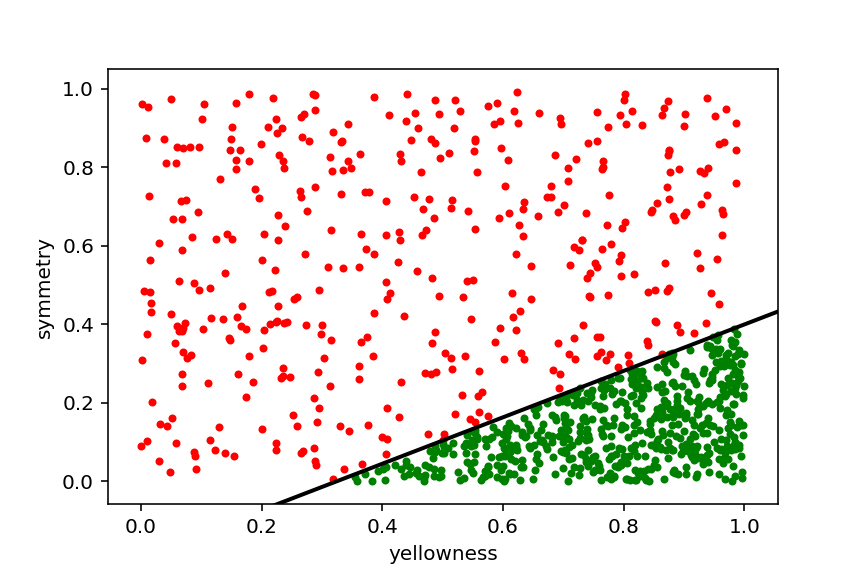

In [15]:
%matplotlib nbagg

np.random.seed(1)
fig = plt.figure()
plt.scatter(data[apples][:, 0], data[apples][:, 1], color = "red", marker=".", label="Apples")
plt.scatter(data[pears][:, 0], data[pears][:, 1], color = "green", marker=".", label="Pears")
plt.xlabel("yellowness")
plt.ylabel("symmetry")
line, = plt.plot([], [], color="black", linewidth=2)  # создаём линию, которая будет показывать границу разделения

from matplotlib.animation import FuncAnimation

perceptron_for_weights_line = create_perceptron(2)  # создаём перцептрон нужной размерности со случайными весами

from functools import partial
weights_ani = partial(
    step_by_step_weights, p=perceptron_for_weights_line, input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis]
)  # про partial почитайте на https://docs.python.org/3/library/functools.html#functools.partial

ani = FuncAnimation(fig, func=plot_line, frames=weights_ani, blit=False, interval=10, repeat=True)
# если Jupyter не показывает вам анимацию - раскомментируйте строчку ниже и посмотрите видео
#ani.save("perceptron_seeking_for_solution.mp4", writer = 'mencoder', fps=15)
plt.show()

Text(0, 0.5, 'Number of errors')

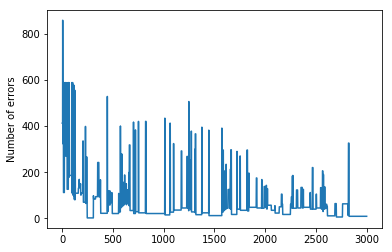

In [9]:
%matplotlib inline
perceptron_for_misclassification = create_perceptron(2)
errors_list = step_by_step_errors(perceptron_for_misclassification, 
                                  input_matrix=data[:, :-1], y=data[:, -1][:,np.newaxis])
plt.plot(errors_list);
plt.ylabel("Number of errors")

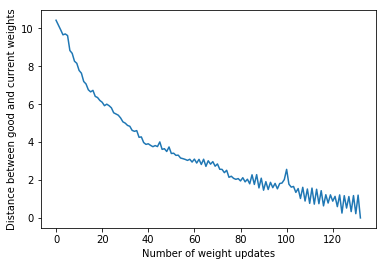

In [13]:
def get_vector(p):
    """возвращает вектор из всех весов перцептрона, включая смещение"""
    v = np.array(list(p.w.ravel()) + [p.b])
    return v

def step_by_step_distances(p, ideal, input_matrix, y, max_steps=1e6):
    """обучает перцептрон p и записывает каждое изменение расстояния от текущих весов до ideal"""
    distances = [norm(get_vector(p) - ideal)]
    i = 0
    errors = 1
    while errors and i < max_steps:
        i += 1
        errors = 0
        for example, answer in zip(input_matrix, y):
            example = example.reshape((example.size, 1))
            
            error = p.train_on_single_example(example, answer)
            errors += error
            if error:
                distances.append(norm(get_vector(p) - ideal))
    return distances

%matplotlib inline

np.random.seed(42)
init_weights = np.random.random_sample(3)
w, b = init_weights[:-1].reshape((2, 1)), init_weights[-1]
ideal_p = Perceptron(w.copy(), b.copy())
ideal_p.train_until_convergence(data[:, :-1], data[:, -1][:,np.newaxis])
ideal_weights = get_vector(ideal_p)

new_p = Perceptron(w.copy(), b.copy())
distances = step_by_step_distances(new_p, ideal_weights, data[:, :-1], data[:, -1][:,np.newaxis])

plt.xlabel("Number of weight updates")
plt.ylabel("Distance between good and current weights")
plt.plot(distances);

In [16]:
def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [17]:
class Neuron:
    
    def __init__(self, weights, activation_function=sigmoid, activation_function_derivative=sigmoid_prime):
        """
        weights - вертикальный вектор весов нейрона формы (m, 1), weights[0][0] - смещение
        activation_function - активационная функция нейрона, сигмоидальная функция по умолчанию
        activation_function_derivative - производная активационной функции нейрона
        """
        
        assert weights.shape[1] == 1, "Incorrect weight shape"
        
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward_pass(self, single_input):
        """
        активационная функция логистического нейрона
        single_input - вектор входов формы (m, 1), 
        первый элемент вектора single_input - единица (если вы хотите учитывать смещение)
        """
        
        result = 0
        for i in range(self.w.size):
            result += float(self.w[i] * single_input[i])
        return self.activation_function(result)
    
    def summatory(self, input_matrix):
        """
        Вычисляет результат сумматорной функции для каждого примера из input_matrix. 
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вектор значений сумматорной функции размера (n, 1).
        """
        return input_matrix.dot(self.w)
    
    def activation(self, summatory_activation):
        """
        Вычисляет для каждого примера результат активационной функции,
        получив на вход вектор значений сумматорной функций
        summatory_activation - вектор размера (n, 1), 
        где summatory_activation[i] - значение суммматорной функции для i-го примера.
        Возвращает вектор размера (n, 1), содержащий в i-й строке 
        значение активационной функции для i-го примера.
        """
        return sigmoid(summatory_activation)
    
    def vectorized_forward_pass(self, input_matrix):
        """
        Векторизованная активационная функция логистического нейрона.
        input_matrix - матрица примеров размера (n, m), каждая строка - отдельный пример,
        n - количество примеров, m - количество переменных.
        Возвращает вертикальный вектор размера (n, 1) с выходными активациями нейрона
        (элементы вектора - float)
        """
        return self.activation(self.summatory(input_matrix))
        
    def SGD(self, X, y, batch_size, learning_rate=0.1, eps=1e-6, max_steps=200):
        """
        Внешний цикл алгоритма градиентного спуска.
        X - матрица входных активаций (n, m)
        y - вектор правильных ответов (n, 1)
        
        learning_rate - константа скорости обучения
        batch_size - размер батча, на основании которого 
        рассчитывается градиент и совершается один шаг алгоритма
        
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        Вторым вариантом была бы проверка размера градиента, а не изменение функции,
        что будет работать лучше - неочевидно. В заданиях используйте первый подход.
        
        max_steps - критерий остановки номер два: если количество обновлений весов 
        достигло max_steps, то алгоритм останавливается
        
        Метод возвращает 1, если отработал первый критерий остановки (спуск сошёлся) 
        и 0, если второй (спуск не достиг минимума за отведённое время).
        """
        
        # Этот метод необходимо реализовать
        
        pass
    
    def update_mini_batch(self, X, y, learning_rate, eps):
        """
        X - матрица размера (batch_size, m)
        y - вектор правильных ответов размера (batch_size, 1)
        learning_rate - константа скорости обучения
        eps - критерий остановки номер один: если разница между значением целевой функции 
        до и после обновления весов меньше eps - алгоритм останавливается. 
        
        Рассчитывает градиент (не забывайте использовать подготовленные заранее внешние функции) 
        и обновляет веса нейрона. Если ошибка изменилась меньше, чем на eps - возвращаем 1, 
        иначе возвращаем 0.
        """
        # Этот метод необходимо реализовать
        
        pass

In [30]:
np.random.seed(42)
n = 10
m = 5

X = 20 * np.random.sample((n, m)) - 10
y = (np.random.random(n) < 0.5).astype(np.int)[:, np.newaxis]
w = 2 * np.random.random((m, 1)) - 1

neuron = Neuron(w)
neuron.update_mini_batch(X, y, 0.1, 1e-5)
neuron.w

array([[-0.22264542],
       [-0.45730194],
       [ 0.65747502],
       [-0.28649335],
       [-0.43813098]])

In [ ]:
comput